### Dorothea Run for Panfetal B cell data

In [1]:
pip install git+https://github.com/saezlab/dorothea-py.git

  Cloning https://github.com/saezlab/dorothea-py.git to /tmp/pip-req-build-_1oub0e7
  Running command git clone -q https://github.com/saezlab/dorothea-py.git /tmp/pip-req-build-_1oub0e7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for dorothea-py: filename=dorothea_py-1.0.5-py3-none-any.whl size=4875467 sha256=076345d8523c42793a4bc9083dbbe126fbee05a3f298bc2bc36946c9c6a18715
  Stored in directory: /tmp/pip-ephem-wheel-cache-eplxwgst/wheels/f9/03/eb/a2bb09383719c3915107bd5b81fc9477b8e12fb3f5b9a62ee2
Successfully built dorothea-py
Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import scvelo as scv 
import sys 
import dorothea 

In [42]:
pip list

Package                       Version
----------------------------- -------------------
absl-py                       0.12.0
aiohttp                       3.7.4.post0
airr                          1.3.1
alabaster                     0.7.12
alembic                       1.5.5
anndata                       0.7.5
annoy                         1.17.0
anyio                         2.2.0
arboreto                      0.1.6
argon2-cffi                   20.1.0
async-generator               1.10
async-timeout                 3.0.1
attrs                         20.3.0
Babel                         2.9.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.1
bbknn                         1.4.1
bleach                        3.3.0
blinker                       1.4
bokeh                         2.3.0
boltons                       20.2.1
brotlipy                      0.7.0
cached-property               1.5.2
cachetools                    4.2.1
certifi                       2020.12.5

In [30]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/Pan_fetal/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

# Load data

Processed datasets in h5ad format are available at https://developmentcellatlas.cellgeni.sanger.ac.uk/fetal-immune.

In [6]:
adata = sc.read('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.LYMPHOID.embedding.h5ad')

Only considering the two last: ['.embedding', '.h5ad'].
Only considering the two last: ['.embedding', '.h5ad'].


In [7]:
adata.raw = adata.copy()

### exclude maternal contaminants

In [8]:
# in github folder metadata/souporcell_results/
maternal_barcodes = pd.read_csv('souporcell/maternal_barcodes.csv')

In [9]:
maternal_barcodes['barcodes'] = [barcode.split('-')[0]+'-'+barcode.split('-')[1] for barcode in maternal_barcodes['x']]

In [11]:
print(sum(adata.obs_names.isin(maternal_barcodes['barcodes'])))
adata = adata[~adata.obs_names.isin(maternal_barcodes['barcodes'])]

2252


### update annotation with anno_lvl_2_final_clean

In [12]:
obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv', index_col = 0) # final annotations and removed maternal contaminant cells

In [13]:
for col in obs:
    adata.obs[col] = obs[col] # use anno_lvl_2_final_clean

Trying to set attribute `.obs` of view, copying.


### subset to B1 and MATURE B

In [14]:
adata_subset = adata[adata.obs['anno_lvl_2_final_clean'].isin(['B1', 'MATURE_B'])] 

### Dorothea Run

In [15]:
# To predict TF activities, first we need to load the DoRothEA network (only available for Human and Mouse):
dorothea_hs = dorothea.load_regulons(organism='Human',commercial=False)  # If working with mouse, set to Mouse; commercial=False  If non-academia, set to True
# Get the Dorothea network
regulons = dorothea.load_regulons(['A','B','C'], organism='Human')#['A','B','C'],   # Which levels of confidence to use (A most confident, E least confident)
# this loads 271 regulons 

In [16]:
dorothea.run(adata_subset, regulons, center=True,  # Center gene expression by mean per cell
             num_perm=100, # Simulate m random activities
             norm=True,    # Normalize by number of edges to correct for large regulons
             scale=True,   # Scale values per feature so that values can be compared across cells
             use_raw=False, # Use raw adata, where we have the lognorm gene expression
             min_size=5,   # TF with less than 5 targets will be ignored
             use_hvg=False
            ) #adata.obsm['dorothea']
#dorothea.extract(adata_T) # generates a new AnnData object with TF activities stored in `.obsm` instead of gene expression. 

5243 targets found


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


In [17]:
adata_subset.obsm['dorothea']

tf,AHR,AR,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,ATF2,ATF3,...,ZKSCAN1,ZNF143,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF592,ZNF639,ZNF740
index,,,,,,,,,,,,,,,,,,,,,
FCAImmP7579224-TACTTGTCAGCTGGCT,0.347576,1.178879,-3.877794,0.350569,0.204197,-0.117073,-1.248119,0.942253,4.655747,0.246551,...,-0.246501,0.492691,0.545908,-0.571276,2.067383,3.988597,-0.430573,0.543383,-0.481005,0.019691
FCAImmP7579224-CGGAGTCAGCAGGCTA,2.721098,-0.090498,0.741218,0.348273,0.188523,0.523806,-0.929450,0.008462,3.231148,-0.862494,...,0.814221,0.747273,1.286075,0.292286,0.296358,3.860362,0.825382,-0.169204,1.633833,1.898886
FCAImmP7579224-TATTACCCACCACCAG,-0.127745,1.544466,0.781399,-0.162089,0.320561,0.485249,0.098199,0.022916,2.021036,-1.687737,...,0.701164,0.092241,0.197737,0.425363,0.057415,2.322823,-0.932813,-1.568673,-0.512797,0.525325
FCAImmP7579224-TGTGTTTCACGGTAGA,-0.183357,-0.332366,-1.648408,0.346855,-0.274748,-0.242997,0.223133,-0.171494,0.471637,0.642960,...,-0.255161,0.116654,0.287404,-0.575780,0.840473,-0.381925,0.680026,-1.039088,0.944684,1.346553
FCAImmP7579224-CACCTTGAGTAGCCGA,5.969008,2.522497,0.444216,1.148205,0.331634,0.475840,-4.025600,2.563171,5.367826,0.005052,...,0.624732,0.673939,0.354728,-0.541261,0.879879,-0.438714,0.047653,-2.151343,-0.499148,0.274909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCAImmP7803020-AGGGATGGTCGCGAAA,-1.650519,-1.421309,1.011906,0.190574,0.204322,0.476113,0.586315,-0.413181,-0.764760,1.201826,...,1.035238,0.476695,-0.121062,-0.122289,-0.597706,-0.130310,0.806045,0.696131,-0.359885,-0.491015
FCAImmP7803020-CGATCGGGTAGAGCTG,-0.099517,-0.216090,0.473769,0.964354,-1.712552,0.476113,0.586315,-0.440007,-0.790693,-1.082904,...,-0.727842,0.662270,-0.103150,-0.027452,-0.381510,-0.607626,0.319263,0.696131,1.276258,0.494898
FCAImmP7803020-ACACCGGGTGTCTGAT,-0.137214,-0.482964,0.739879,0.388120,0.118078,-2.330526,0.367106,-0.489916,-0.717445,0.521790,...,-0.671796,-1.340881,-1.114883,-0.141872,-0.224772,-0.607626,0.712962,0.696131,-0.477137,-0.307409


In [121]:
# WRITE FILE
#adata_subset.write_h5ad('PAN.A01.v01.entire_data_normalised_log.20210429.LYMPHOID.embedding.DOROTHEA_B_Subset.h5ad') 

#### Looking at the Top 25 significant TFs

In [ ]:
# READ FILE
#adata_subset = anndata.read_h5ad('PAN.A01.v01.entire_data_normalised_log.20210429.LYMPHOID.embedding.DOROTHEA_B_Subset.h5ad) 

In [18]:
B1_query_test = dorothea.rank_tfs_groups(adata_subset, groupby='anno_lvl_2_final_clean', group='B1')
MATURE_B_query_test = dorothea.rank_tfs_groups(adata_subset, groupby='anno_lvl_2_final_clean', group='MATURE_B')

In [24]:
B1_query_test_pos = B1_query_test.loc[B1_query_test['meanchange']>0,:] # choose the TFs that have upregulated activity in B1

In [25]:
B1_query_test_pos

,group,reference,statistic,meanchange,pval,pval_adj
name,,,,,,
CEBPD,B1,all,46.000224,0.837932,0.000000e+00,0.000000e+00
STAT4,B1,all,50.022397,0.765528,0.000000e+00,0.000000e+00
ERG,B1,all,36.932514,0.617271,1.390213e-298,1.255826e-296
ETV4,B1,all,33.463563,0.552602,1.634242e-245,1.107199e-243
BACH2,B1,all,30.001006,0.552280,9.521321e-198,5.160556e-196
...,...,...,...,...,...,...
BATF,B1,all,1.522555,0.005812,1.278700e-01,1.526553e-01
TFDP1,B1,all,-17.642416,0.003909,1.163775e-69,5.840425e-69
STAT5B,B1,all,2.261217,0.003905,2.374579e-02,3.021178e-02


In [26]:
# sorting TFs according to p-value
significant_top_25 = B1_query_test_pos.sort_values('pval_adj')[0:25]
adata_B1 = adata_subset[adata_subset.obs.anno_lvl_2_final_clean == 'B1']
adata_MATURE_B = adata_subset[adata_subset.obs.anno_lvl_2_final_clean == 'MATURE_B']

In [44]:
significant_top_25.index

Index(['CEBPD', 'STAT4', 'ERG', 'ETV4', 'BACH2', 'TCF4', 'JUN', 'PAX5', 'KLF1',
       'MYC', 'JUNB', 'E2F4', 'CEBPA', 'HIF1A', 'ZNF263', 'IRF4', 'MEF2C',
       'HOXA9', 'SP1', 'LYL1', 'SPI1', 'CREB3', 'AR', 'NR1H2', 'MEF2A'],
      dtype='object', name='name')

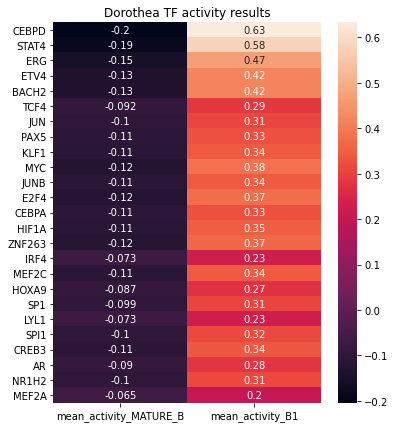

In [38]:
TF_mean_activity_ref = []
TF_mean_activity_query = []

top25= list(significant_top_25.index)
t = dorothea.extract(adata_B1).obsm['dorothea'][top25]
for TF in top25:
    TF_mean_activity_query.append(np.mean(t[TF]) )
    
t = dorothea.extract(adata_MATURE_B).obsm['dorothea'][top25]
for TF in top25:
    TF_mean_activity_ref.append(np.mean(t[TF]) )
    
df1 = pd.DataFrame([TF_mean_activity_ref, TF_mean_activity_query])
df1 = df1.transpose()
df1.columns = ['mean_activity_MATURE_B','mean_activity_B1' ]
df1.index = top25

plt.subplots(figsize=(6,7))
sb.heatmap(df1, annot=True)
plt.title('Dorothea TF activity results')
plt.savefig(fig_path+'B1_dorothea.pdf',bbox_inches='tight')

#### Check regulons

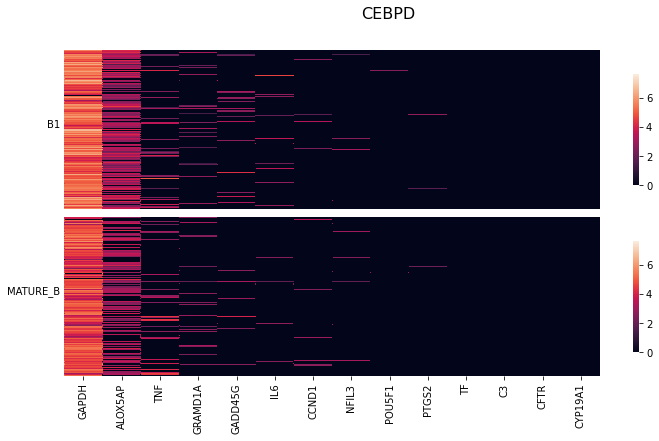

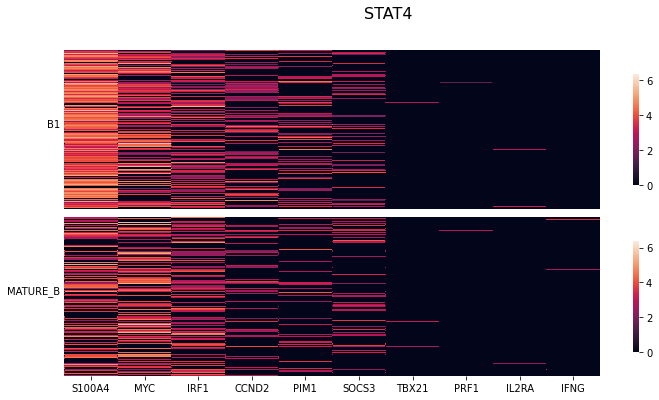

In [34]:
dorothea.check_regulon(adata_subset, regnet=regulons, tf='CEBPD', groupby='anno_lvl_2_final_clean')
dorothea.check_regulon(adata_subset, regnet=regulons, tf='STAT4', groupby='anno_lvl_2_final_clean')

... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'organ' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical
... storing 'AnnatomicalPart' as categorical
... storing 'Sample' as categorical
... storing 'anno_lvl_2_final_clean' as categorical


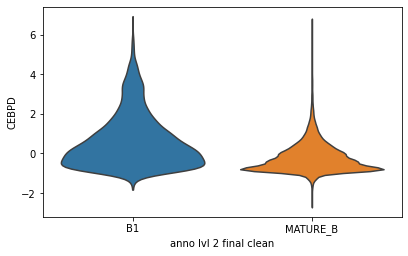

In [35]:
sc.pl.violin(dorothea.extract(adata_subset), keys='CEBPD', groupby='anno_lvl_2_final_clean', stripplot=False)